# Energy Matching: 2D Tutorial

This notebook demonstrates training a scalar energy potential on a 2D dataset, mapping from an "8 Gaussians" distribution to a "Two Moons" target. The trained model is then used to perform:

**Unconditional sample generation**


Define the neural potential network used for energy modeling.

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn

class PotentialModel(nn.Module):
    def __init__(self, dim=2, w=128, time_varying=True):
        super().__init__()
        self.time_varying = time_varying
        self.net = nn.Sequential(
            nn.Linear(dim + (1 if time_varying else 0), w),
            nn.ReLU(),
            nn.Linear(w, w),
            nn.SiLU(),
            nn.Linear(w, w),
            nn.SiLU(),
            nn.Linear(w, w),
            nn.SiLU(),
            nn.Linear(w, 1)
        )

    def forward(self, x, t=None):
        if not self.time_varying:
            return self.net(x)
        if t is None:
            raise ValueError('time_varying=True but t is None.')
        if t.dim() == 0:
            t = t.expand(x.size(0)).unsqueeze(-1)
        elif t.dim() == 1:
            if t.size(0) != x.size(0):
                t = t.expand(x.size(0)).unsqueeze(-1)
            else:
                t = t.unsqueeze(-1)
        t_clamped = torch.clamp(t, max=0.0)
        inp = torch.cat([x, t_clamped], dim=-1)
        return self.net(inp)


Set hyperparameters and train the potential function.

In [3]:
from utils_2D import train

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
epochs_phase1 = 20000
epochs_phase2 = 10000
batch_size = 256
lr = 1e-4
flow_loss_weight = 1.0
ebm_loss_weight = 1.0
sigma = 0.1
save_dir = "2D_toy"

# Noise schedule hyperparams (now fully user-controlled)
tau_star = 0.8       # time at which noise begins
epsilon_max = 0.15   # final (and ramp) noise level

model = train(
    PotentialModel,
    device=device,
    batch_size=batch_size,
    lr=lr,
    epochs_phase1=epochs_phase1,
    epochs_phase2=epochs_phase2,
    flow_weight=flow_loss_weight,
    ebm_weight=ebm_loss_weight,
    sigma=sigma,
    save_dir=save_dir,
    tau_star=tau_star,
    epsilon_max=epsilon_max
)

### Update for Unconditional Generation

This is the update for **unconditional sample generation**. At each step $n$, the state $x^{(n)}$ is updated using Langevin dynamics based on the learned potential $V_{\theta}(x)$:

```math
x^{(n+1)} = x^{(n)} - \Delta t\, \nabla_x V_{\theta}(x^{(n)}) + \sqrt{2 \, \varepsilon^{(n)} \Delta t}\, \eta^{(n)}, \quad \eta^{(n)} \sim \mathcal{N}(0, I),
```
where $\varepsilon^{(n)} = \varepsilon(n\Delta t)$  follows a piecewise linear **temperature schedule** given by:

$
\varepsilon(t) = 
\begin{cases}
0, & 0 \le t < \tau^*, \\[6pt]
\varepsilon_{\max}\,\frac{t - \tau^*}{1 - \tau^*}, & \tau^* \le t \le 1, \\[6pt]
\varepsilon_{\max}, & t \ge 1.
\end{cases}
$

Here, $\tau^*$ is the time when the temperature starts ramping up from $0$ to $\varepsilon_{\max}$, and for $t\ge1$, the temperature remains constant at its maximum value.

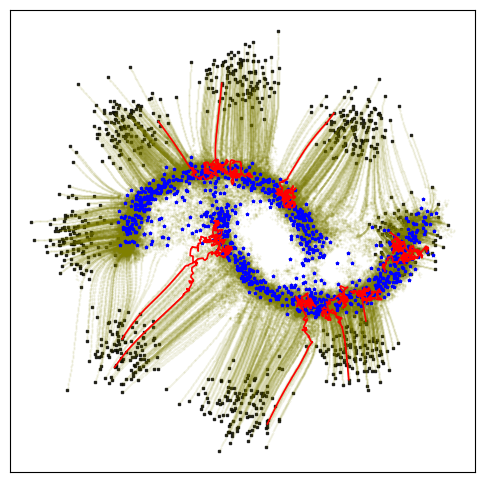

In [4]:
from utils_2D import simulate_piecewise_length, plot_trajectories_custom
from torchcfm.utils import sample_8gaussians

# Use the same tau_star, epsilon_max we used for training.
x_init = sample_8gaussians(1024).to(next(model.parameters()).device)

traj_np, times_np = simulate_piecewise_length(
    model,
    x_init,
    dt=0.01,
    max_length=400,
    tau_star=tau_star,
    epsilon_max=epsilon_max
)

plot_trajectories_custom(traj_np)